# Installing and importing dependencies and libraries

In [1]:
!pip install cdlib scikit-learn pandas plotly hvplot community python-louvain networkx

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 18.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   --------------------------- ------------ 4.7/6.9 MB 2

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import networkx as nx
from cdlib import algorithms, evaluation
import csv
# import sys
# import itertools
import numpy as np
# from itertools import count
# import holoviews as hv
# import hvplot.networkx as hvnx
# import plotly.graph_objects as go
import pandas as pd
# import random
import os
import seaborn as sns

from sklearn.metrics import rand_score
from sklearn.metrics import adjusted_rand_score
# from sklearn.metrics import f1_score
# from sklearn.metrics.pairwise import euclidean_distances

from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.spatial import distance
# from scipy.cluster.hierarchy import dendrogram, linkage

from networkx.algorithms import approximation
# from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.centrality import closeness_centrality

import matplotlib.pyplot as plt
# import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'wurlitzer', 'bayanpy', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


# Data Exploration

### Checking if Cho is a proper subset of KEGG

In [4]:
cho_data = pd.read_csv('../dataset/Cho_Ours.txt', sep='\t')
cho_genes = cho_data.iloc[:, 0]

kegg_data = pd.read_csv('../dataset/Kegg_Subcluster.txt', sep='\t')
kegg_genes = kegg_data.iloc[:, 0]

cho_genes_in_kegg = cho_genes.isin(kegg_genes)
print("Are all cho_genes present in kegg_genes?", cho_genes_in_kegg.all())
print("Missing genes in kegg_genes:")
cho_genes_not_in_kegg = cho_genes[~cho_genes_in_kegg]
print(cho_genes_not_in_kegg)

Are all cho_genes present in kegg_genes? False
Missing genes in kegg_genes:
18     YLR273c
34     YKL042w
39     YNL225c
43     YLR313c
44     YGR041w
61     YJL173c
80     YMR179w
85     YDL227c
86     YNL173c
101    YMR198w
103    YDR356w
111    YDL197c
123    YIR017c
130    YKL049c
131    YCL014w
132    YOR188w
140    YLR014c
150    YBR138c
154    YJR092w
155    YLR353w
168    YDL048c
Name: Gene, dtype: object


# Network Formation (Cho_Ours.txt)
Value-based Network Construction, using delta = 0.85

In [5]:
delta = 0.85

Dataset = []

# open and read a tab-separated values (TSV) file, storing the first 19 columns in dataset
with open('../dataset/Cho_Ours.txt') as tsv:
    for line in csv.reader(tsv, dialect="excel-tab"):
        Dataset.append(line[:20])

# remove the header (if any) to ensure dataset contains only data
Dataset = Dataset[1:]

# calculates the number of nodes (n) based on the length of the dataset
n = len(Dataset)
print(n)

# creates an empty Networkx graph G
G = nx.Graph()

# add nodes to the graph G, each with specific attributes derived from the dataset

G.add_nodes_from([
    (
        i,  # node identifier, a unique number for each node
        {
            "label": Dataset[i][0],  # 'label' attribute, usually a name from the dataset
            "group": Dataset[i][1:3],  # 'group' attribute, a category, converted to integer
            "data": Dataset[i][3:]  # 'data' attribute, containing all remaining data points for the node

        }
    )
    for i in range(n)  # loop through each item in the dataset, where 'n' is the total number of items
])

# define edges between nodes based on specific conditions
for i in range(n):
    for j in range(i+1, n):

        #print(G.nodes[i])
        #print(G.nodes[j])

        # convert the 'data' attribute of both nodes to float for calculations
        x = [float(xi) for xi in G.nodes[i]["data"]]
        y = [float(yi) for yi in G.nodes[j]["data"]]

        # calculate distances and correlation coefficients between nodes
        d = distance.euclidean(x,y)
        m = distance.minkowski(x,y)
        pearson = np.corrcoef(x,y)[0][1]
        spearman, ps = spearmanr(x,y)
        kendall, pk = kendalltau(x,y)

        # add an edge if the Pearson correlation coefficient is above the threshold (delta)
        if pearson>=delta:
            G.add_edge(i,j, euc = d, mink= m, weight = pearson, spearman = spearman, kendall = kendall)

# ------------------------------------------------------------

Degree = dict(G.degree)
nx.set_node_attributes(G, Degree, 'degree')
print("Number of Nodes", len(G.nodes()))
print("Number of Edges", G.number_of_edges())
print("Transitivity", nx.transitivity(G))

# calculate and print the average clustering coefficient
print(approximation.average_clustering(G, trials=1000, seed=10))

# identify connected components in the graph G and print their sizes and labels
Connected_Components = [G.subgraph(c).copy() for c in nx.connected_components(G) if len(c)>1]

# used to keep track of the size of the largest connected component found so far
max = -1

# store the actual connected component that is the largest
BigC = []

# if the size (len(c)) of the current component c is greater than the current max
# update max with the new larger size
# and update BigC to be this current component.

for c in Connected_Components:
    if len(c) > max:
        max = len(c)
        BigC = c

# printing the size of the largest connected component
print("Max Component with", len(BigC))

nx.set_node_attributes(G, -1, 'gn_grp')

# ------------------------------------------------------------

# total number of nodes in the original graph before removing singletons
original_node_count = G.number_of_nodes()

# create a subgraph that contains only nodes in connected components
subG = nx.compose_all(Connected_Components)

# total number of nodes in the subgraph after removing singletons
subgraph_node_count = subG.number_of_nodes()

# calculate and print the number of singletons removed
singletons_removed = original_node_count - subgraph_node_count
print(f"Number of singletons removed: {singletons_removed}")

170
Number of Nodes 170
Number of Edges 866
Transitivity 0.6545242605274662
0.464
Max Component with 85
Number of singletons removed: 38


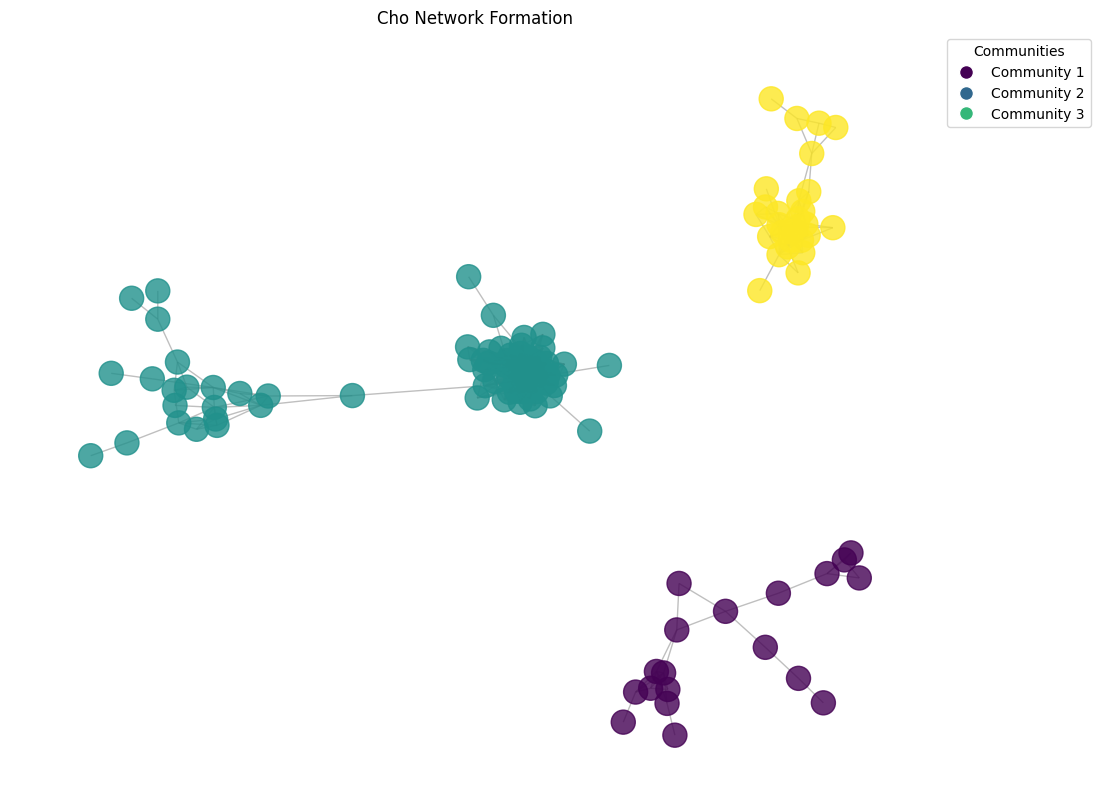

In [7]:
# create a color map, one color for each component
components = list(nx.connected_components(subG))
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = i
colors = [color_map[node] for node in subG.nodes()]

pos = nx.spring_layout(subG)

# draw the graph
plt.figure(figsize=(12, 10))
nodes = nx.draw_networkx_nodes(subG, pos, alpha=0.8, node_color=colors, cmap=plt.get_cmap('viridis'))
nx.draw_networkx_edges(subG, pos, alpha=0.5, edge_color='gray')

# create a legend
# generate a color for each component using the same colormap and normalization
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, len(components))
legend_colors = [cmap(norm(i)) for i in range(len(components))]  # Generate legend colors

# Create a legend with a color box for each component
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"Community {i+1}",
                          markerfacecolor=legend_colors[i], markersize=10) for i in range(len(components))]

plt.title('Cho Network Formation')
plt.axis('off')
plt.legend(handles=legend_elements, title='Communities', bbox_to_anchor=(1, 1))




plt.show()